In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from casadi.tools.graph import dotgraph

from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())

import sys
sys.path.insert(0, '../python/pyecca')

from pyecca.util import rk4

This notebooks demonstrates how to design reference trajectories for a rocket using the nonlinear optimization tools within Casadi.

In [2]:
def derive_equations():
    p_x = ca.SX.sym('p_x')
    p_z = ca.SX.sym('p_z')
    v_x = ca.SX.sym('v_x')
    v_z = ca.SX.sym('v_z')
    theta = ca.SX.sym('theta')
    omega = ca.SX.sym('omega')
    thrust = ca.SX.sym('thrust')
    g = ca.SX.sym('g')
    t = ca.SX.sym('t')

    x = ca.vertcat(p_x, p_z, v_x, v_z, theta)
    u = ca.vertcat(omega)
    p = ca.vertcat(thrust, g)

    dx = ca.vertcat(v_x, v_z, thrust*ca.cos(theta), thrust*ca.sin(theta) - g, omega)
    return {
        'rhs': ca.Function('rhs', [x, u, p], [dx])
    }

Solve_Succeeded


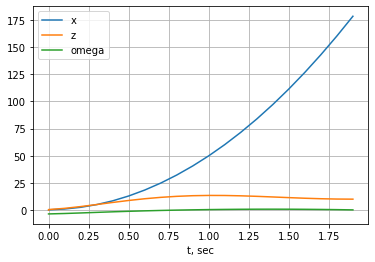

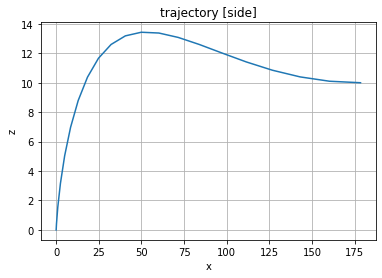

In [3]:
def objective(eqs, x_vect, u_vect, p):
    return ca.dot(u_vect, u_vect)

def constraint(eqs, x_vect, u_vect, p):
    uf = u_vect[-1]
    xf = x_vect[:, -1]
    #x_dot = eqs['rhs'](xf, uf, p)
    return ca.vertcat(
        xf[1] - 10,  # be at 10 m altitude
        xf[3],  # don't change altitude
    )
    
def optimize_trajectory(eqs, x0, p, t0, tf, h):
    # symbolic integration
    x = x0
    
    t_vect = np.arange(t0, tf, h)
    n = len(t_vect)
    u_vect = ca.SX.sym('u', n)
    x_vect = x0

    for t, u in zip(t_vect, u_vect):
        x = rk4(lambda t, x: eqs['rhs'](x, u, p), t, x, h)
        x_vect = ca.horzcat(x_vect, x)
    # NLP declaration
    nlp = {'x':u_vect,'f':objective(eqs, x, u_vect, p),'g':constraint(eqs, x_vect , u_vect, p)};
    S = ca.nlpsol('S', 'ipopt', nlp, {
        'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
        })
    n_g = 1
    res = S(x0=np.zeros(n),
            lbg=np.zeros(n_g), ubg=np.zeros(n_g),
            lbx=-10*np.ones(n), ubx=10*np.ones(n)
           )
    stats = S.stats()
    print(stats['return_status'])
    u_opt = res['x']
    return t_vect, u_opt, x

def simulate(eqs, x0, p, t_vect, u_vect):
    data = {
        't': [t_vect[0]],
        'x': [np.reshape(x0, -1)],
        'u': [u_vect[0]]
    }
    x = x0
    h = t_vect[1] - t_vect[0] # assumes equally spaced
    for t, u in zip(t_vect, u_vect):
        x = rk4(lambda t, x: eqs['rhs'](x, u, p), t, x, h)
        data['t'].append(t)
        data['u'].append(u)
        data['x'].append(np.reshape(x, -1))
    for k in data.keys():
        data[k] = np.array(data[k], dtype=float)
    return data

p = ca.vertcat(100, 9.8)
eqs = derive_equations()
x0 = ca.DM([0, 0, 0, 0, np.deg2rad(75)])
t_vect, u_opt, x = optimize_trajectory(eqs, x0=x0, p=p, t0=0, tf=2, h=0.1)
data = simulate(eqs, x0, p, t_vect, u_opt)

plt.figure()
plt.plot(data['t'], data['x'][:, 0], label='x')
plt.plot(data['t'], data['x'][:, 1], label='z')
plt.plot(data['t'], data['u'], label='omega')
plt.xlabel('t, sec')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(data['x'][:, 0], data['x'][:, 1])
plt.xlabel('x')
plt.ylabel('z')
plt.grid(True)
plt.title('trajectory [side]')
plt.savefig('rocket_ref_trajectory.png')

In [5]:
print(data)
print(data.keys())

{'t': array([0. , 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1,
       1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]), 'x': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.30899694e+00],
       [ 1.85425836e-01,  4.13425622e-01,  4.24588761e+00,
         8.01485448e+00,  9.50542678e-01],
       [ 9.41383912e-01,  1.53843557e+00,  1.12507933e+01,
         1.41116607e+01,  6.30465467e-01],
       [ 2.49436332e+00,  3.15728853e+00,  2.00222824e+01,
         1.78702140e+01,  3.60145131e-01],
       [ 4.97539970e+00,  5.03704740e+00,  2.96883180e+01,
         1.93754078e+01,  1.43165280e-01],
       [ 8.44191593e+00,  6.96953205e+00,  3.96586505e+01,
         1.89996520e+01, -2.21049120e-02],
       [ 1.29066457e+01,  8.78982203e+00,  4.96200398e+01,
         1.72103801e+01, -1.40020763e-01],
       [ 1.83617525e+01,  1.03795829e+01,  5.94596948e+01,
         1.44603090e+01, -2.15955080e-01],
       [ 2.47946365e+01,  1.16630682e+01,  6.9182641